In [2]:
import os
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import seaborn as sns


In [3]:

# File paths
signal_files_lowX_lowY = [
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X500_Y60/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X500_Y70/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X500_Y80/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X500_Y90/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X500_Y95/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X500_Y100/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y60/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y70/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y80/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y90/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y95/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y100/preselection"),
]

background_files = [
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GJetPt40/preselection"),
]

In [4]:
# Columns to be loaded
keys = [
    'bbgg_mass', 'dibjet_pt', 'diphoton_pt', 'bbgg_pt', 'bbgg_eta', 'bbgg_phi',
    'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi', 'diphoton_eta', 
    'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 
    'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 
    'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 'CosThetaStar_jj', 
    'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 'phosublead_PtOverM', 
    'FirstJet_PtOverM', 'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass', 
    'weight_preselection',
]


In [5]:
# Load DataFrames
dfs = {}

# Load signal files
for file, key in signal_files_lowX_lowY:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

# Load background files
for file, key in background_files:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

# Combine signal DataFrames
signal_df = pd.concat([dfs[key] for key in dfs if 'NMSSM' in key], ignore_index=True)
background_df = pd.concat([dfs[key] for key in dfs if 'GJet' in key or 'GGJets' in key], ignore_index=True)



# signal_df = pd.concat([])
# Print combined sample sizes
print(f'Total Signal Shape: {signal_df.shape}')
print(f'Total Background Shape: {background_df.shape}')


Total Signal Shape: (100763, 33)
Total Background Shape: (98635, 33)


In [6]:
# Check if 'weight_preselection' exists in all DataFrames
if 'weight_preselection' not in signal_df.columns or 'weight_preselection' not in background_df.columns:
    print("Error: 'weight_preselection' column missing in one or more DataFrames.")
    exit()

# Assign labels
signal_df['label'] = 1
background_df['label'] = 0

In [7]:
# Combine signal and background data
combined_df = pd.concat([signal_df, background_df], ignore_index=True)
print(f'Combined DataFrame Shape: {combined_df.shape}')

# Define features and labels
features = [
    'bbgg_eta', 'bbgg_phi', 'bbgg_mass', 'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_eta', 
    'sublead_pho_phi', 'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 
    'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 
    'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 
    'phosublead_PtOverM', 'FirstJet_PtOverM', 'SecondJet_PtOverM', 'diphoton_bbgg_mass', 
    'dibjet_bbgg_mass'
]

Combined DataFrame Shape: (199398, 34)


In [8]:

X = combined_df[features]
y = combined_df['label']
weights = combined_df['weight_preselection']

# Impute missing values and scale the data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Extract weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [9]:
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



In [10]:
# Define the neural network model
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.output(x))
        return x

In [11]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available.
Device name: Tesla T4


In [12]:
import torch
import torch.nn as nn
from torch.optim import Adam

# Initialize the model
input_dim = X_train.shape[1]
model = SimpleDNN(input_dim)  # No device assignment needed
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = (outputs > 0.5).float()  # Convert outputs to binary predictions
    correct = (preds == labels).float().sum()  # Count correct predictions
    accuracy = correct / labels.size(0)  # Compute accuracy
    return accuracy

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for X_batch, y_batch, weight_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, y_batch).item()

    # Average training accuracy
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)


    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for X_batch, y_batch, weight_batch in test_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_outputs.append(outputs.numpy())
            test_labels.append(y_batch.numpy())
    
    # Combine lists into numpy arrays
    test_outputs = np.concatenate(test_outputs)
    test_labels = np.concatenate(test_labels)
    
    # Calculate test accuracy
    test_accuracy = calculate_accuracy(torch.tensor(test_outputs), torch.tensor(test_labels)).item()

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch 1/50, Train Loss: 618.4066, Train Accuracy: 0.9548
Epoch 1/50, Test Loss: 126.1229, Test Accuracy: 0.9627
Epoch 2/50, Train Loss: 517.1403, Train Accuracy: 0.9630
Epoch 2/50, Test Loss: 117.4105, Test Accuracy: 0.9660
Epoch 3/50, Train Loss: 483.3979, Train Accuracy: 0.9652
Epoch 3/50, Test Loss: 115.4059, Test Accuracy: 0.9662
Epoch 4/50, Train Loss: 470.2990, Train Accuracy: 0.9663
Epoch 4/50, Test Loss: 111.2442, Test Accuracy: 0.9682
Epoch 5/50, Train Loss: 459.4233, Train Accuracy: 0.9673
Epoch 5/50, Test Loss: 108.5831, Test Accuracy: 0.9689
Epoch 6/50, Train Loss: 451.2256, Train Accuracy: 0.9677
Epoch 6/50, Test Loss: 107.1693, Test Accuracy: 0.9693
Epoch 7/50, Train Loss: 443.7579, Train Accuracy: 0.9691
Epoch 7/50, Test Loss: 104.3226, Test Accuracy: 0.9703
Epoch 8/50, Train Loss: 436.1835, Train Accuracy: 0.9692
Epoch 8/50, Test Loss: 102.3118, Test Accuracy: 0.9702
Epoch 9/50, Train Loss: 429.9693, Train Accuracy: 0.9695
Epoch 9/50, Test Loss: 102.9941, Test Accuracy:

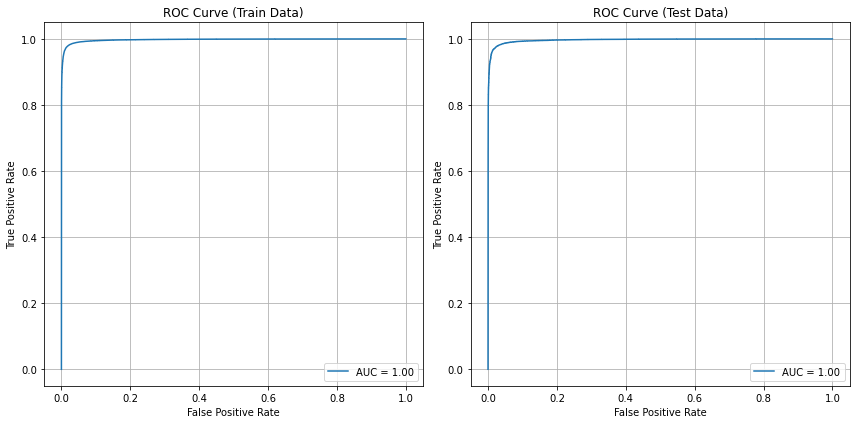

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Move tensors to CPU before converting to NumPy arrays
y_train_pred = model(X_train_tensor).cpu().detach().numpy()
y_test_pred = model(X_test_tensor).cpu().detach().numpy()

# Plot ROC curves and calculate AUC
def plot_roc(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.grid(True)
    plt.legend()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_roc(y_train, y_train_pred, 'ROC Curve (Train Data)')

plt.subplot(1, 2, 2)
plot_roc(y_test, y_test_pred, 'ROC Curve (Test Data)')

plt.tight_layout()
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/midX_highY_ROC.png")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/midX_highY_ROC.pdf")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Plot Training and Testing Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

# Plot Training and Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


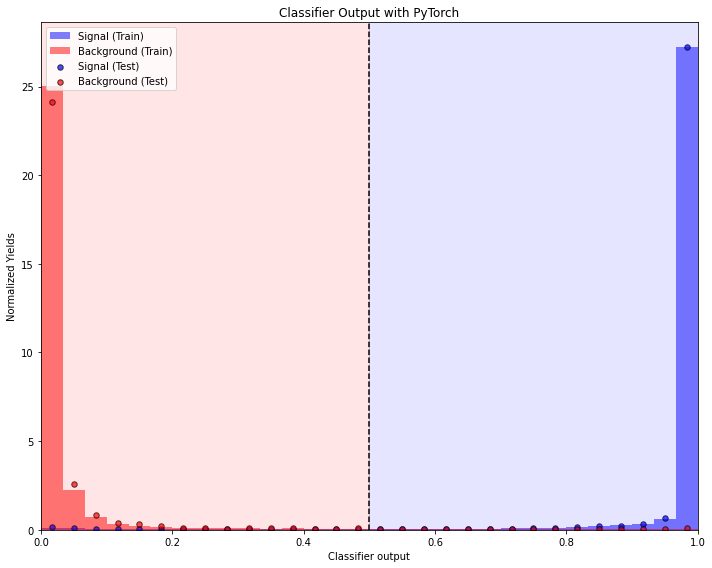

In [14]:
# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in loader:
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)
# Get predictions for training and test data
train_preds, train_true = get_predictions(train_loader, model)
test_preds, test_true = get_predictions(test_loader, model)

# Convert weights tensors to NumPy arrays
X_train_weights_np = X_train_weights_tensor.numpy()
X_test_weights_np = X_test_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)  

# Calculate histograms and bins for training data with weights
train_hist_s, _ = np.histogram(train_preds[train_true == 1], bins=bins, density=True, weights=X_train_weights_np[train_true == 1])
train_hist_b, _ = np.histogram(train_preds[train_true == 0], bins=bins, density=True, weights=X_train_weights_np[train_true == 0])

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for training data
plt.figure(figsize=(10, 8))
plt.hist(train_preds[train_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal (Train)', density=True, weights=X_train_weights_np[train_true == 1])
plt.hist(train_preds[train_true == 0], bins=bins, color='red', alpha=0.5, label='Background (Train)', density=True, weights=X_train_weights_np[train_true == 0])

# Calculate histograms for test data
test_hist_s, _ = np.histogram(test_preds[test_true == 1], bins=bins, density=True, weights=X_test_weights_np[test_true == 1])
test_hist_b, _ = np.histogram(test_preds[test_true == 0], bins=bins, density=True, weights=X_test_weights_np[test_true == 0])

# Plot scatter points for test data
plt.scatter(bin_centers, test_hist_s, color='blue', alpha=0.7, label='Signal (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, test_hist_b, color='red', alpha=0.7, label='Background (Test)', marker='o', s=30, edgecolor='k')


# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0,1)
plt.legend()
plt.title('Classifier Output with PyTorch')

# Save and display the plotpurple
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/midX_highY_classifier_output_plot.png")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/midX_highY_classifier_output_plot.pdf")
plt.tight_layout()
plt.show()

In [ ]:
# Correlation plot 

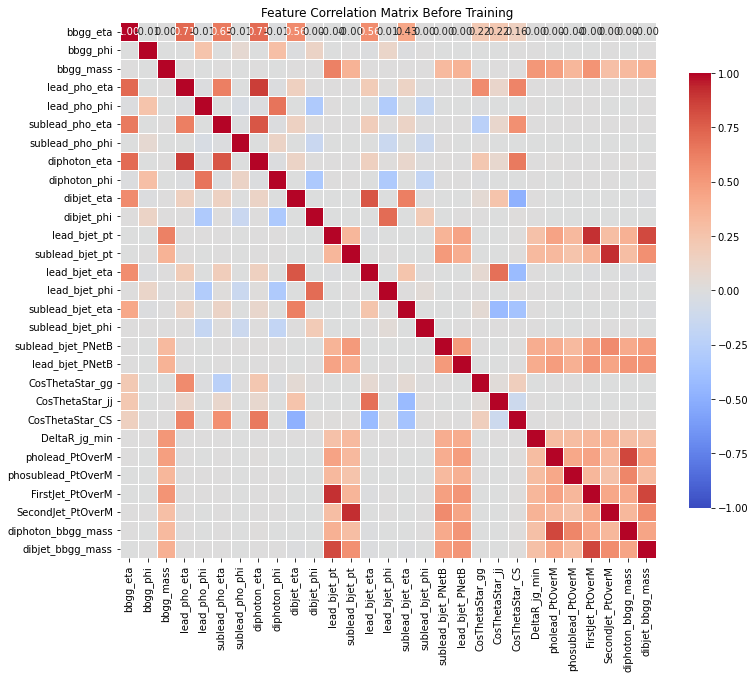

In [15]:
# Plot correlation matrix before training
X_train_df = pd.DataFrame(X_train_scaled, columns=features)
corr_matrix_before = X_train_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_before, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1,
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Feature Correlation Matrix Before Training')
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/midX_highY_correlation_before_training.png")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/midX_highY_correlation_before_training.pdf")
plt.show()

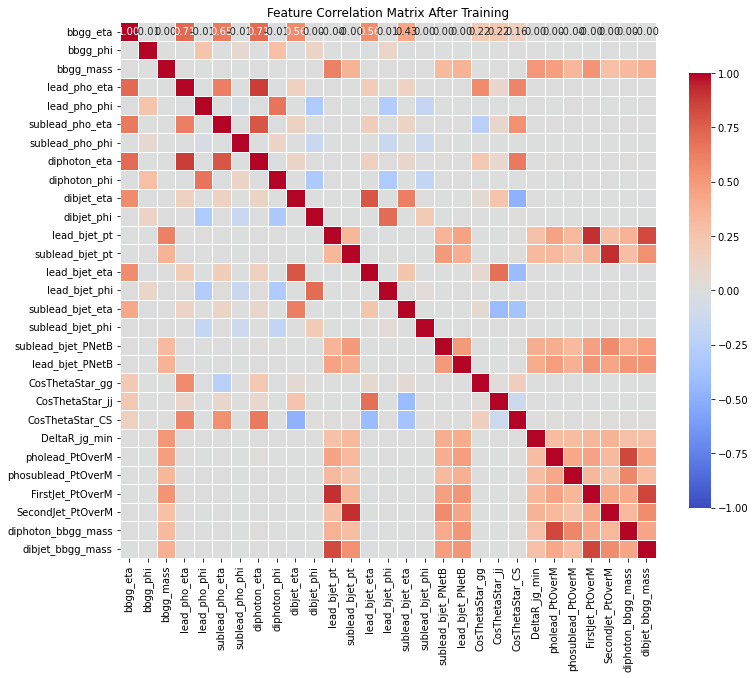

In [16]:
# Plot correlation matrix after training
X_train_after_df = pd.DataFrame(X_train_scaled, columns=features)
corr_matrix_after = X_train_after_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_after, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1,
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Feature Correlation Matrix After Training')
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/midX_midY_correlation_after_training.png")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/midX_midY_correlation_after_training.pdf")
plt.show()